In [1]:
## Importing Libraries
!pip install -r requirements.txt

In [2]:
## Importing Libraries
import os
import sys
import time
import pickle
import scipy
import autograd
import importlib
import cv2
from scipy.spatial import cKDTree
import autograd.numpy as np
import gtsam as gt
from gtsam import Pose3, Rot3, Point3
import transforms3d as t3d
import matplotlib.pyplot as plt
from collections import defaultdict
import open3d as o3d
sys.path.append(os.path.abspath("code"))  # Add folder to path
from load_data import load_data
import pr2_utils as utils
import constants as const
from plot_helper import robot_trajectory_plot, robot_trajectory_plot2, occupancy_plot


sys.path.append(os.path.abspath("code/icp_warm_up"))  # Add folder to path
import utils as icp_utils

In [ ]:
dataset = 21
data = load_data(dataset)
data_path = "/Users/varunmoparthi/Desktop/SLAM_and_ICP-master/data" ## Update this datapath


data.keys(), data['encoder'].keys(), data['imu'].keys()

(dict_keys(['dataset', 'encoder', 'lidar', 'imu', 'kinect']),
 dict_keys(['encoder_counts', 'encoder_stamps']),
 dict_keys(['imu_angular_velocity', 'imu_linear_acceleration', 'imu_stamps']))

#### 1. Encoder and IMU odometry

In [4]:
'''
Motion Model for differnetial drive robot under euler discretization over a time interval of length τ_t:

          [x_(t+1)]                   [v_t * cos(θ_t)]
x_(t+1) = [y_(t+1)]   := x_t + τ_t *  [v_t * sin(θ_t)]
          [θ_(t+1)]                   [ω_t]

'''

def motion_model(initial_pose: np.ndarray, velocity: np.ndarray, angular_velocity: np.ndarray, dt: np.ndarray) -> np.ndarray:
    X_t = [initial_pose]
    for i in range(len(velocity)):
        x, y, theta = X_t[-1]
        dx, dy = velocity[i] * np.cos(theta) * dt[i], velocity[i] * np.sin(theta) * dt[i]
        dtheta = angular_velocity[i] * dt[i]
        X_t.append([x + dx, y + dy, theta + dtheta])
    return np.array(X_t).T


In [5]:
def trajectory(X):
    T = []
    for i in range(X.shape[1]):
        x_t, y_t, theta_t = X[:, i]
        T_t = np.eye(4)
        T_t[:2, 3] = [x_t, y_t]
        T_t[0, 0] = np.cos(theta_t)
        T_t[0, 1] = -np.sin(theta_t)
        T_t[1, 0] = np.sin(theta_t)
        T_t[1, 1] = np.cos(theta_t)
        T.append(T_t)
    return T

In [6]:
def robot_trajectory(data: defaultdict) -> None:
    encoder_data = data['encoder']
    imu_data = data['imu']

    X_0 = [0, 0, 0]
    yaw = imu_data['imu_angular_velocity'][2, :]
    
    dt = np.diff(encoder_data["encoder_stamps"])
    wheel_radius = 0.0022 / 2  # L/2
    velocity_left = wheel_radius * np.sum(encoder_data['encoder_counts'][[0,2], 1:], axis=0) / dt
    velocity_right = wheel_radius * np.sum(encoder_data['encoder_counts'][[1,3], 1:], axis=0) / dt
    velocity = (velocity_left + velocity_right) / 2
    
    encoder_match_angular = utils.match_stamps(encoder_data["encoder_stamps"][1:], imu_data['imu_stamps'][:-1]) ## Maps encoder timestamp to nearest angular timestamp
    angular_velocity = yaw[[encoder_match_angular[ts] for ts in encoder_data["encoder_stamps"][1:]]] ## Yaw, finding the one closest to encoder timestamp
    
    X = motion_model(X_0, velocity, angular_velocity, dt)
    robot_trajectory_plot(X, f"Robot trajectory for dataset: {data['dataset']}", ["x", "y"])
    return X, yaw, encoder_match_angular


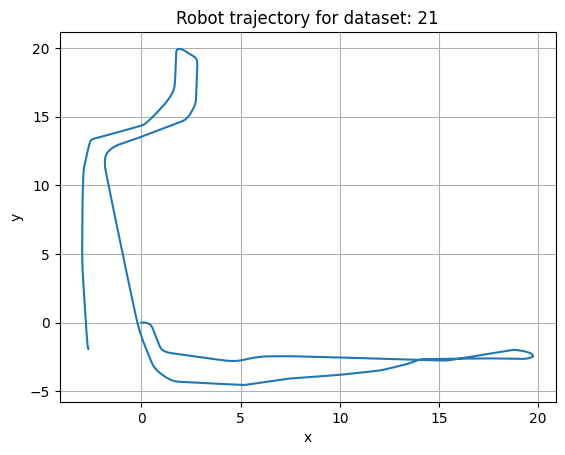

In [ ]:
X, yaw, encoder_match_angular = robot_trajectory(data) 
poses_X = trajectory(X) 

#### 2.Point-cloud registration via iterative closest point (ICP)

##### 2.1 Warm up

In [8]:
def preprocess_point_cloud(pc):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc)
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    return np.asarray(cl.points)

def find_nearest_neighbors(src_pts, tgt_pts, tree=None):
    if tree is None:
        tree = cKDTree(tgt_pts)
    distances, indices = tree.query(src_pts)
    return indices, distances, tree

def kabsch_algorithm(source, target):

    centroid_source = np.mean(source, axis=0)
    centroid_target = np.mean(target, axis=0)
    source_centered = source - centroid_source
    target_centered = target - centroid_target

    H = source_centered.T @ target_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        print("Reflection detected in Kabsch algorithm! Fixing it...")
        Vt[-1, :] *= -1  
        R = Vt.T @ U.T
    t = centroid_target - R @ centroid_source

    return R, t

def icp_algorithm(source, target, init_pose=np.eye(4), max_iterations=50, tolerance=1e-6, trim_ratio=0.1):
    N = source.shape[0]
    current_pose = init_pose.copy()
    
    source_h = np.hstack((source, np.ones((N, 1))))  
    transformed_src = (current_pose @ source_h.T).T[:, :3]

    prev_error = np.inf
    tree = cKDTree(target)  
    for iteration in range(max_iterations):
        nn_indices, distances, tree = find_nearest_neighbors(transformed_src, target, tree)
        sorted_indices = np.argsort(distances)
        keep_count = int((1 - trim_ratio) * len(distances))
        trimmed_indices = sorted_indices[:keep_count]
        tgt_corr = target[nn_indices[trimmed_indices]]
        src_corr = transformed_src[trimmed_indices]

        mse = np.mean(distances[trimmed_indices]**2)

        if np.abs(prev_error - mse) < tolerance:
            print(f"Converged at iteration {iteration} with MSE: {mse:.6f}")
            break
        prev_error = mse

        R, t = kabsch_algorithm(src_corr, tgt_corr)

        T_delta = np.eye(4)
        T_delta[:3, :3] = R
        T_delta[:3, 3] = t

        current_pose = T_delta @ current_pose
        transformed_src = (current_pose @ source_h.T).T[:, :3]

        print(f"Iteration {iteration}: MSE = {mse:.6f}")

    return current_pose, mse

def icp_with_yaw_inits(source, target, yaw_range=(-np.pi/2, np.pi/2), yaw_steps=144,
                       max_iterations=50, tolerance=1e-6):
    best_pose = None
    best_loss = np.inf
    yaw_angles = np.linspace(yaw_range[0], yaw_range[1], yaw_steps)

    for yaw in yaw_angles:
        init_pose = np.eye(4)
        cos_yaw = np.cos(yaw)
        sin_yaw = np.sin(yaw)
        init_pose[0, 0] = cos_yaw
        init_pose[0, 1] = -sin_yaw
        init_pose[1, 0] = sin_yaw
        init_pose[1, 1] = cos_yaw
        pose, loss = icp_algorithm(source, target, init_pose,max_iterations, tolerance, 0.05)   
        print(f"Yaw init: {yaw:.2f} rad -> Loss: {loss:.4f}")
        if loss < best_loss:
            best_loss = loss
            best_pose = pose
    return best_pose, best_loss

In [8]:
obj_name = 'drill'  
num_pc = 4  
target_pc_raw = icp_utils.read_canonical_model(obj_name)  # (N, 3)
target_pc = preprocess_point_cloud(target_pc_raw)
poses = []
for i in range(num_pc):
    source_pc_raw = icp_utils.load_pc(obj_name, i)  # (M, 3)
    
    print(f"Processing Point Cloud {i}...")
    
    source_pc = preprocess_point_cloud(source_pc_raw)

    estimated_pose, final_loss = icp_with_yaw_inits(source_pc, target_pc, (-np.pi/2, np.pi/2), 100, 60, 1e-6)
    poses.append(estimated_pose)
    
    print(f"Point Cloud {i}: Best Loss = {final_loss:.4f}")
    
    icp_utils.visualize_icp_result(source_pc, target_pc, estimated_pose)
    icp_utils.save_combined_icp_result(source_pc, target_pc, estimated_pose, f"./code/icp_warm_up/results/{obj_name}/{i}.ply")

./code/icp_warm_up/data/drill/model.mat
Processing Point Cloud 0...
Iteration 0: MSE = 0.278452
Iteration 1: MSE = 0.000918
Iteration 2: MSE = 0.000324
Iteration 3: MSE = 0.000194
Iteration 4: MSE = 0.000145
Iteration 5: MSE = 0.000122
Iteration 6: MSE = 0.000110
Iteration 7: MSE = 0.000102
Iteration 8: MSE = 0.000096
Iteration 9: MSE = 0.000092
Iteration 10: MSE = 0.000088
Iteration 11: MSE = 0.000084
Iteration 12: MSE = 0.000080
Iteration 13: MSE = 0.000075
Iteration 14: MSE = 0.000069
Iteration 15: MSE = 0.000062
Iteration 16: MSE = 0.000057
Iteration 17: MSE = 0.000052
Iteration 18: MSE = 0.000047
Iteration 19: MSE = 0.000042
Iteration 20: MSE = 0.000038
Iteration 21: MSE = 0.000034
Iteration 22: MSE = 0.000029
Iteration 23: MSE = 0.000025
Iteration 24: MSE = 0.000022
Iteration 25: MSE = 0.000018
Iteration 26: MSE = 0.000015
Iteration 27: MSE = 0.000013
Iteration 28: MSE = 0.000012
Converged at iteration 29 with MSE: 0.000011
Yaw init: -1.57 rad -> Loss: 0.0000
Iteration 0: MSE = 0

KeyboardInterrupt: 

##### Visualise the Combined ICP result

In [9]:
icp_utils.visualise_combined_icp_result("/Users/varunmoparthi/Desktop/ECE276A/ECE276A_PR2/code/icp_warm_up/results/drill/1.ply")

##### 2.2 Scan Matching

In [9]:
def lidar_to_xyz(data):
    """
    Convert LiDAR data to X, Y, Z coordinates with timestamps.
    Returns:
    - xyz_coords: Array of shape (n_scans * n_points, 4) containing X, Y, Z coordinates and timestamps.
    """
 
    angle_min = data["lidar_angle_min"]
    angle_max = data["lidar_angle_max"]
    angle_inc = data['lidar_angle_increment']
    ranges = data['lidar_ranges']
    timestamps = data["lidar_stamps"]
    lidar_range_max = data["lidar_range_max"]
    lidar_range_min = data["lidar_range_min"]
 
    n_points, n_scans = ranges.shape
    print("No of scans: ", n_scans)
    
    point_clouds = []

    for i, timestamp in enumerate(timestamps):
        ranges_1d = ranges[:, i]  
        angles = np.linspace(angle_min, angle_max, n_points)
        valid_ranges  = (ranges_1d > lidar_range_min) & (ranges_1d < lidar_range_max)
        
        x_coords = ranges_1d[valid_ranges] * np.cos(angles[valid_ranges])
        y_coords = ranges_1d[valid_ranges] * np.sin(angles[valid_ranges])
        z_coords = np.zeros_like(x_coords)
        
        point_cloud = np.column_stack((x_coords, y_coords, z_coords, np.full_like(x_coords, i)))
        point_clouds.append(point_cloud)
    
    xyz_coords = np.vstack(point_clouds)
    return xyz_coords


In [10]:
lidar_data, encoder_data = data['lidar'], data['encoder']
xyz_coords_lidar = lidar_to_xyz(lidar_data)
print(xyz_coords_lidar.shape)

No of scans:  4785
(5155320, 4)


In [85]:
encoder_data = data['encoder']
encoder_stamps = encoder_data['encoder_stamps']
lidar_stamps = lidar_data['lidar_stamps']
encoder_match_lidar = utils.match_stamps(encoder_stamps, lidar_stamps)
kinect_data = data['kinect']
rgbd_stamps = kinect_data['rgb_stamps']
disp_stamps = kinect_data['disp_stamps']
encoder_match_rgbd = utils.match_stamps(encoder_stamps, rgbd_stamps)
encoder_match_disp = utils.match_stamps(encoder_stamps, disp_stamps)

In [12]:
encoder_match_lidar = utils.match_stamps(encoder_stamps, lidar_stamps)

In [13]:
def scan_matching_icp(lidar_data, trajectory, encoder_data, xyz_coords):
    poses_rela = []  
    poses = [np.eye(4)]
    lidar_offset = np.eye(4)
    lidar_offset[0, 3] = 0.13323
    lidar_offset[1, 3] = 0
    lidar_offset[2, 3] = 0.51435
    encoder_match_lidar = utils.match_stamps(encoder_data["encoder_stamps"], lidar_data["lidar_stamps"])
    encoder_stamps = encoder_data['encoder_stamps']

    for i in range(0, len(encoder_stamps) - 1):
        timestamp_t = encoder_stamps[i]
        timestamp_t1 = encoder_stamps[i + 1]
        
        source = preprocess_point_cloud(xyz_coords[xyz_coords[:, 3] == encoder_match_lidar[timestamp_t]][:, :3])
        target = preprocess_point_cloud(xyz_coords[xyz_coords[:, 3] == encoder_match_lidar[timestamp_t1]][:, :3])
        x_t, y_t, theta_t = trajectory[:, i]
        x_t1, y_t1, theta_t1 = trajectory[:, i+1]
        
        T_t = np.eye(4)
        T_t[:2, 3] = [x_t, y_t]
        T_t[0, 0] = np.cos(theta_t)
        T_t[0, 1] = -np.sin(theta_t)
        T_t[1, 0] = np.sin(theta_t)
        T_t[1, 1] = np.cos(theta_t)
        T_t = T_t @ lidar_offset

        T_t1 = np.eye(4)
        T_t1[:2, 3] = [x_t1, y_t1]
        T_t1[0, 0] = np.cos(theta_t1)
        T_t1[0, 1] = -np.sin(theta_t1)
        T_t1[1, 0] = np.sin(theta_t1)
        T_t1[1, 1] = np.cos(theta_t1)
        T_t1 = T_t1 @ lidar_offset
        
        init_pose = np.linalg.inv(T_t) @ T_t1
        relative_pose, _ = icp_algorithm(target, source, init_pose, max_iterations=50, tolerance=1e-6, trim_ratio=0.1)
        global_pose = poses[-1] @ relative_pose
        poses.append(global_pose)
        poses_rela.append(relative_pose)
        
    trajectory_xyz = np.array([pose[:3, 3] for pose in poses]).T
    robot_trajectory_plot(trajectory_xyz, "Robot Trajectory using ICP", ["x", "y"])
    
    return trajectory_xyz, poses, poses_rela


Iteration 0: MSE = 0.000041
Iteration 1: MSE = 0.000039
Converged at iteration 2 with MSE: 0.000039
Iteration 0: MSE = 0.000000
Converged at iteration 1 with MSE: 0.000000
Iteration 0: MSE = 0.000035
Converged at iteration 1 with MSE: 0.000035
Iteration 0: MSE = 0.000038
Converged at iteration 1 with MSE: 0.000037
Iteration 0: MSE = 0.000036
Converged at iteration 1 with MSE: 0.000036
Iteration 0: MSE = 0.000035
Converged at iteration 1 with MSE: 0.000035
Iteration 0: MSE = 0.000040
Converged at iteration 1 with MSE: 0.000039
Iteration 0: MSE = 0.000039
Converged at iteration 1 with MSE: 0.000038
Iteration 0: MSE = 0.000040
Converged at iteration 1 with MSE: 0.000039
Iteration 0: MSE = 0.000039
Converged at iteration 1 with MSE: 0.000039
Iteration 0: MSE = 0.000035
Converged at iteration 1 with MSE: 0.000035
Iteration 0: MSE = 0.000036
Converged at iteration 1 with MSE: 0.000035
Iteration 0: MSE = 0.000036
Converged at iteration 1 with MSE: 0.000035
Iteration 0: MSE = 0.000040
Converge

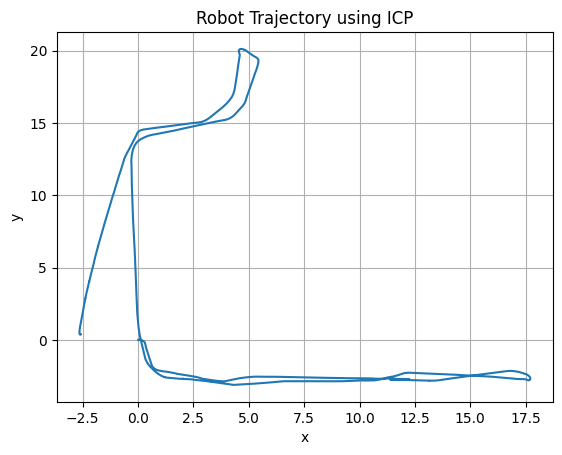

In [14]:
trajectory_xyz, poses, relative_poses = scan_matching_icp(lidar_data, X, encoder_data, xyz_coords_lidar)

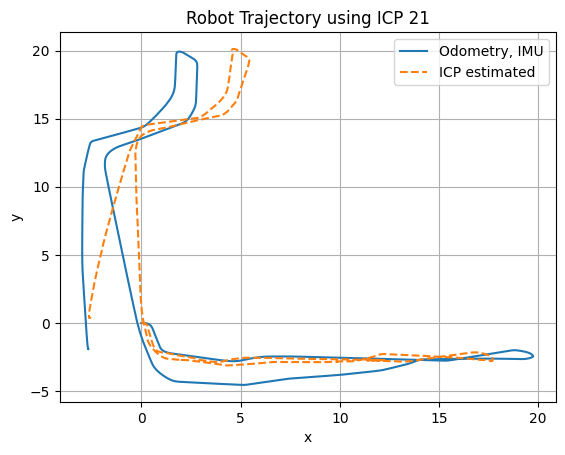

In [15]:
robot_trajectory_plot2(X, trajectory_xyz, f"Robot Trajectory using ICP {dataset}", ["x", "y"], ["Odometry, IMU", "ICP estimated"])

#### 3. Occupancy and Texture mapping

##### 3.1 Occupancy Grid

In [16]:
MAP_o = const.MAP.MAP


def occupancy_map(MAP, poses, encoder_data, xyz_coords_lidar):
    lidar_offset = np.eye(4)
    lidar_offset[0, 3] = 0.13323
    lidar_offset[1, 3] = 0
    lidar_offset[2, 3] = 0.51435
    min_map_val = -5 * np.log(4) 
    max_map_val = 5 * np.log(4) 
    
    encoder_stamps = encoder_data['encoder_stamps']
    encoder_match_lidar = utils.match_stamps(encoder_stamps, lidar_data["lidar_stamps"])

    for i, timestamp_t in enumerate(encoder_stamps):
        curr_pose = np.dot(poses[i], lidar_offset)
        point_cloud = xyz_coords_lidar[xyz_coords_lidar[:, 3] == encoder_match_lidar[timestamp_t]][:, :3]
        point_cloud = np.dot(point_cloud, curr_pose[:3, :3].T) + curr_pose[:-1, -1]

        lidar_grid_pts = np.floor((point_cloud[:, :2] - const.MAP.MIN) / const.MAP.RES).astype(int) - 1
        grid_x, grid_y = lidar_grid_pts[:, 0], lidar_grid_pts[:, 1]

        start_pt = np.floor((curr_pose[:-1, -1][:2] - const.MAP.MIN) / const.MAP.RES).astype(int)

        for x, y in zip(grid_x, grid_y):
            x_, y_ = utils.bresenham2D(start_pt[0], start_pt[1], x, y)
            MAP[y_.astype(np.int32)[:-1], x_.astype(np.int32)[:-1]] -= np.log(4)

        MAP[grid_y, grid_x] += np.log(4)
        np.clip(MAP, min_map_val, max_map_val, out=MAP)
        print(i)
        # if i == 200:
        #     break
    return MAP

In [17]:
MAP_o = occupancy_map(MAP_o, poses, encoder_data, xyz_coords_lidar)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

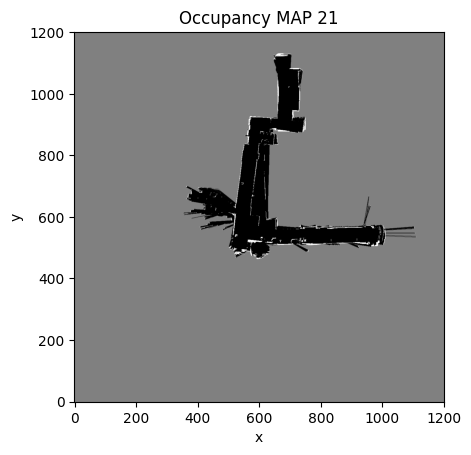

In [19]:
occupancy_plot(MAP_o, f"Occupancy MAP {dataset}", ["x", "y"])

##### 3.2 Texture Mapping

In [86]:
MAP_t = {}
MAP_t['res'] = np.array([0.05, 0.05])    
MAP_t['min'] = np.array([-20.0, -20.0])  
MAP_t['max'] = np.array([30.0, 30.0])    
MAP_t['size'] = np.ceil((MAP_t['max'] - MAP_t['min']) / MAP_t['res']).astype(int)
MAP_t['size'] += 1 
MAP_t['map'] = np.zeros((MAP_t['size'][0], MAP_t['size'][1], 3))

In [87]:
def texture_map(poses, encoder_data, MAP):
    K = np.array([[585.05, 0, 242.94],
        [0, 585.05, 315.84],
        [0, 0, 1]])
    Ro_r = np.array([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
    encoder_stamps = encoder_data["encoder_stamps"]
    for i in range(len(encoder_stamps) -1):

        timestamp_t = encoder_stamps[i]
        rgb_stamp_t= encoder_match_rgbd[timestamp_t] + 1
        disp_stamp_t = encoder_match_disp[timestamp_t]+1

        rgb_img = cv2.cvtColor(cv2.imread(f"{data_path}/dataRGBD/RGB{dataset}/rgb{dataset}_{rgb_stamp_t}.png"), cv2.COLOR_BGR2RGB)
        disp_img = cv2.imread(f"{data_path}/dataRGBD/Disparity{dataset}/disparity{dataset}_{disp_stamp_t}.png", cv2.IMREAD_UNCHANGED)
        dd = np.array(-0.00304 * disp_img + 3.31)
        depth = 1.03 / dd

        IMAGE = np.meshgrid(np.arange(0, disp_img.shape[0]), np.arange(0, disp_img.shape[1]), indexing='ij')  
        rgb_i = np.array((526.37 * IMAGE[0].flatten() + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  
        rgb_j = np.array((526.37 * IMAGE[1].flatten() + 16662) / 585.051, dtype=np.int32)
        rgb_i = np.clip(rgb_i, 0, disp_img.shape[0] - 1)
        rgb_j = np.clip(rgb_j, 0, disp_img.shape[1] - 1)
        
        points = Ro_r.T @ (depth.flatten() * (np.linalg.inv(K) @ np.vstack([IMAGE[1].flatten(), IMAGE[0].flatten(), np.ones_like(IMAGE[0].flatten())])) )
        cam2body_T= np.zeros([4,4])
        cam2body_T[:3,:3]= t3d.euler.euler2mat(0,0.36,0.021)
        cam2body_T[:, -1]= np.hstack((np.array([0.18,0.005,0.36]), np.array([1])))
        points_world = poses[i] @ cam2body_T @ np.vstack([points, np.ones(points.shape[1])])
        world_xy = points_world[:2, :].T

        world_xy = world_xy[np.where((points_world[2, :] < 0.5))]
        grid_xy = np.round((world_xy - MAP['min']) / MAP['res']).astype(int)
        grid_x, grid_y = grid_xy[:, 0], grid_xy[:, 1]
        grid_valid = (grid_x >= 0) & (grid_y >= 0)  & (grid_x < MAP['size'][0]) &  (grid_y < MAP['size'][1])
        color = rgb_img[rgb_i, rgb_j]
        color = color[np.where((points_world[2, :] < 0.5))]/255.0
        grid_x, grid_y, color = grid_x[grid_valid], grid_y[grid_valid], color[grid_valid]

        MAP['map'][grid_y, grid_x] = color
    return MAP['MAP']

In [88]:
MAP_t = texture_map(poses, encoder_data, MAP_t)


KeyboardInterrupt: 

In [ ]:
plt.title(f'Textured Map {Dataset}')
plt.imshow(MAP_t, origin='lower')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### 4. Pose graph optimization and loop closure

##### 4.1 Factor graph in GTSAM

In [72]:
def gtsam(poses, relative_poses, noise):
    graph = gt.NonlinearFactorGraph()
    pose_estimate = gt.Values()

    first_pose = Pose3(Rot3(poses[0][:3, :3]), Point3(poses[0][:-1, -1]))
    graph.add(gt.PriorFactorPose3(0, first_pose, noise))
    pose_estimate.insert(0, first_pose)

    for i in range(1, len(poses)):
        R_rel, p_rel = relative_poses[i - 1][:3, :3], relative_poses[i - 1][:-1, -1]
        relative_pose = Pose3(Rot3(R_rel), Point3(p_rel))
        pose_i = Pose3(Rot3(poses[i][:3, :3]), Point3(poses[i][:-1, -1]))
        graph.add(gt.BetweenFactorPose3(i - 1, i, relative_pose, noise))
        pose_estimate.insert(i, pose_i)

    optimizer = gt.LevenbergMarquardtOptimizer(graph, pose_estimate)
    result = optimizer.optimize()

    optimized_poses = np.array([
        np.vstack((
            np.hstack((result.atPose3(i).rotation().matrix(), result.atPose3(i).translation().reshape(3, 1))),
            [0, 0, 0, 1]
        ))
        for i in range(len(poses))
    ])
    return optimized_poses[:, :3, 3].T

In [73]:
noise = gt.noiseModel.Diagonal.Sigmas([0.01] * 6)
optim_trajectory_xyz = gtsam(poses, relative_poses, noise)

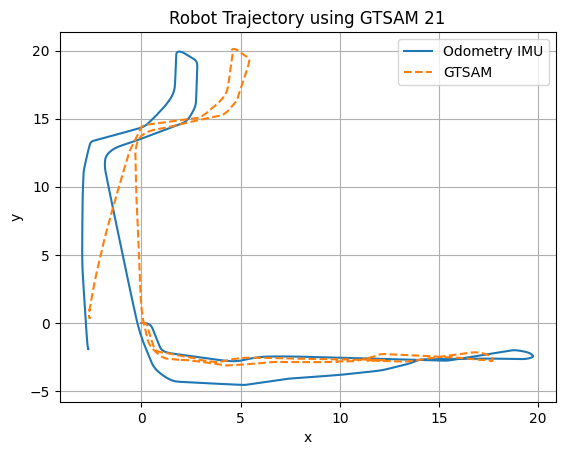

In [74]:
robot_trajectory_plot2(X, optim_trajectory_xyz, f"Robot Trajectory using GTSAM {dataset}", ["x", "y"], ["Odometry IMU", "GTSAM"])